# Setting

In [1]:
from pf_utils import DataManager, FinancialRatios, BacktestManager, MomentumPortfolio
from pf_widgets import WidgetUniverse, WidgetTransaction

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
metrics2 = [
    'total_return', 'cagr', 'monthly_vol', 'monthly_sharpe',
    'max_drawdown', 'avg_drawdown','avg_drawdown_days', 
]

path_data = 'data'
path_tran = 'transaction'

In [3]:
file_bt_price = 'kospi200_prices_000306_240707.csv'
file_bt_ratio = 'kospi200_ratios_170531_240930.csv'

# Data

## Universe: KOSPI200

In [4]:
k200 = DataManager(
    universe = 'kospi200',
    #file = file_bt_price,
    file = 'kospi200_prices.csv',
    path = path_data
)
k200.upload()

201 assets from 2021-01-04 to 2024-10-17 uploaded.
df_prices updated


In [5]:
df_k200 = k200.df_prices
assetnames_k200 = k200.get_names()

### data for backtesting

In [6]:
if k200.file_historical == file_bt_price:
    cond = df_k200.notna().sum(axis=1) > 170
    df_k200 = df_k200.loc[cond].dropna(axis=1)
df_k200.columns.size

201

## Ratios

In [7]:
WidgetUniverse

In [8]:
if k200.file_historical == file_bt_price:
    file = file_bt_ratio
else:
    file = 'kospi200_ratios.csv'

fr = FinancialRatios(file, path_data)

Financial ratios of 201 stocks from 2023-01-02 to 2024-10-16 loaded


In [9]:
start = '2023-01-01'
tickers = df_k200.columns.to_list()
kw = dict(
    freq = 'd',
    close_today = WidgetUniverse.values(1)
)
fr.download(tickers, start, **kw) if WidgetUniverse.values(0) else None

In [10]:
#fr.calc_rank(metrics='PER', date='start', topn=None)
fr.calc_rank(metrics='PER', topn=None)

Ranking score of PER on 2024-10-16


ticker
010060    0.000000
003030    0.006211
016380    0.012422
009970    0.018634
047040    0.024845
            ...   
009420    0.975155
329180    0.981366
377300    0.987578
450080    0.993789
004800    1.000000
Name: PER, Length: 162, dtype: float64

In [11]:
#fr.calc_historical()
fr.calc_historical(['PER', 'PBR'])

Historical of PER+PBR ranking score created


ticker  date      
005930  2023-01-02    1.115655
        2023-01-03    1.120757
        2023-01-04    1.146513
        2023-01-05    1.162310
        2023-01-06    1.167412
                        ...   
016380  2024-10-10    0.207072
        2024-10-11    0.224572
        2024-10-14    0.204572
        2024-10-15    0.207072
        2024-10-16    0.201547
Name: PER, Length: 86908, dtype: float64

In [12]:
#fr.get_stats(stats_daily=False)
fr.get_stats()

Returning stats of daily averages


,BPS,PER,PBR,EPS,DIV,DPS
start,2023-01-02,2023-01-02,2023-01-02,2023-01-02,2023-01-02,2023-01-02
end,2024-10-16,2024-10-16,2024-10-16,2024-10-16,2024-10-16,2024-10-16
mean,105788.5,68.9,2.3,8780.0,2.4,1817.4
std,3542.4,40.8,0.3,1352.9,0.1,122.5


## Reshape for backtest

In [13]:
df_p = fr.util_reshape(df_k200)

fratios_dict = dict()
for r in ['PER', 'PBR']:
    df = fr.interpolate(df_p, r)
    fratios_dict[r] = fr.util_reshape(df, stack=False)

In [14]:
fratios_dict[r].tail()

ticker,000080,000100,000120,000150,000210,000240,000270,000660,000670,000720,...,361610,373220,375500,377300,383220,402340,450080,454910,457190,489790
date,,,,,,,,,,,,,,,,,,,,,
2024-10-10,1.28,5.77,0.50,1.91,0.26,0.41,0.86,2.40,0.18,0.42,...,1.11,4.95,0.25,1.76,1.97,0.75,10.57,9.08,15.21,0.0
2024-10-11,1.28,5.87,0.50,2.00,0.25,0.41,0.86,2.39,0.18,0.41,...,1.07,4.76,0.25,1.77,1.87,0.75,10.15,9.07,14.40,0.0
2024-10-14,1.29,5.74,0.50,2.11,0.26,0.40,0.86,2.41,0.19,0.42,...,1.05,4.70,0.25,1.77,1.94,0.77,10.17,9.13,14.14,0.0
2024-10-15,1.29,5.95,0.49,2.08,0.25,0.40,0.85,2.48,0.19,0.41,...,1.03,4.67,0.25,1.78,1.88,0.77,9.69,9.08,13.91,0.0
2024-10-16,1.28,5.77,0.49,2.09,0.25,0.41,0.83,2.43,0.19,0.41,...,0.99,4.69,0.25,1.77,1.82,0.76,9.93,8.91,13.81,0.0


# Backtest

## Example

In [23]:
fratio = 'PER'
df_ratio = fratios_dict[fratio]

In [15]:
kwargs_bm = dict(
    initial_capital = 1e7,
    commissions = 0,
    align_axis = None, 
    days_in_year = 246,
    asset_names = assetnames_k200
)
bm = BacktestManager(df_k200, **kwargs_bm)

running self.util_check_days_in_year to check days in a year
171 assets from 2017-05-10 to 2024-07-05 uploaded.


In [16]:
bm.benchmark_ticker()

Benchmark is KODEX200


In [17]:
#bm.buy_n_hold(name='PER', weigh='equally')

In [18]:
select = 'f-ratio'
kwargs_build = dict(
    name=f'{select}', select =select, weigh='Equally', 
    n_assets=5, freq='Y', lookback=5,
    df_ratio=df_ratio, ratio_descending=True
)
bm.build(**kwargs_build)

Backtesting 2 strategies: KODEX200, f-ratio


100%|██████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 15709.00it/s]

Returning stats


,KODEX200,f-ratio
start,2017-05-09,2017-05-09
end,2024-07-05,2024-07-05
total_return,0.545298,0.393314
cagr,0.062699,0.047437
calmar,0.164837,0.087122
max_drawdown,-0.38037,-0.544485
avg_drawdown,-0.04033,-0.085891
avg_drawdown_days,78.46875,126.75
daily_vol,0.18247,0.29995
daily_sharpe,0.432459,0.307699


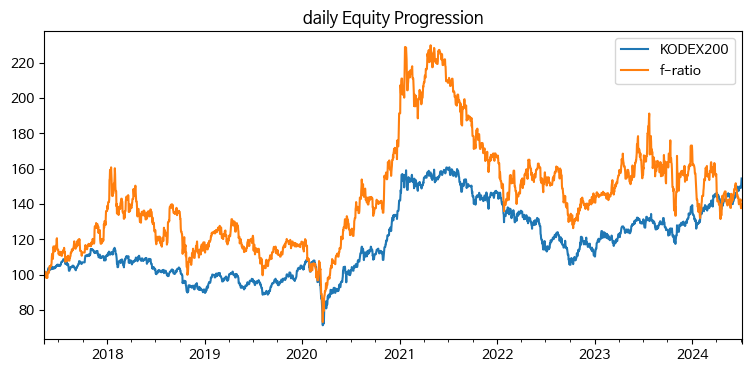

In [20]:
bm.run(figsize=(9,4), stats_sort_by='cagr')

In [21]:
bm.portfolios

0) KODEX200
1) f-ratio

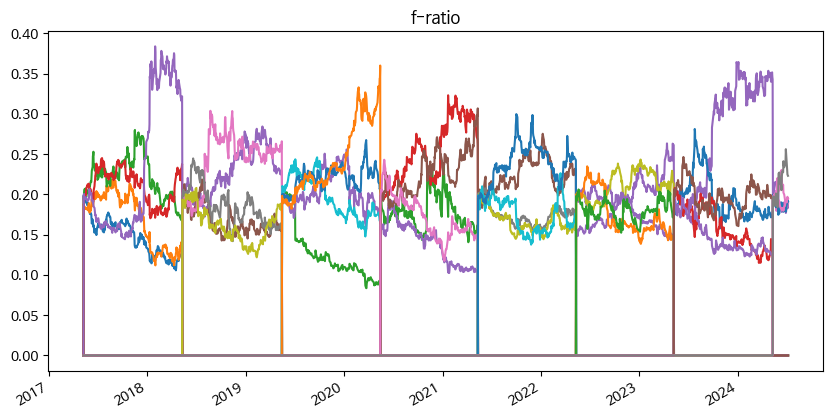

In [22]:
bm.plot_security_weights(1, legend=False)

## Parameter study

In [24]:
n_test = 500
df_train = df_k200.iloc[:-n_test]
df_test = df_k200.iloc[-n_test:]

In [25]:
kwargs_bm = dict(
    initial_capital = 1e7,
    commissions = 0,
    align_axis = None, 
    days_in_year = 246,
    asset_names = assetnames_k200
)

In [26]:
bm = BacktestManager(df_train, **kwargs_bm)

running self.util_check_days_in_year to check days in a year
171 assets from 2017-05-10 to 2022-06-24 uploaded.


In [27]:
bm.benchmark_ticker()

Benchmark is KODEX200


In [28]:
from itertools import product

params = dict(
    #p_fr = ['PER', 'PBR', 'PER+PBR'],
    p_fr = ['PER', 'PBR'],
    p_ast = [5, 10, 20, 30],
    p_freq = [130, 250, 500],
    p_lb = [0, 5, 10, 20, 30, 60]
)
p_comb = list(product(*params.values()))
kwa_list = [{'name':f'{x[0]}:a{x[1]}/f{x[2]}/lb{x[3]}',
             'df_ratio':fratios_dict[x[0]], 'n_assets':x[1], 'freq':x[2], 'lookback':x[3]} 
            for x in p_comb]

kwargs_build = dict(
    select='F-ratio', weigh='Equally', ratio_descending=False
)
bm.build_batch(*kwa_list, **kwargs_build)

In [29]:
df_res = bm.run(stats_sort_by='cagr', plot=False)
df_res.iloc[:, :5]

Backtesting 145 strategies: KODEX200, PER:a5/f130/lb0, ... , PBR:a30/f500/lb60


100%|█████████████████████████████████████████████████████████████| 145/145 [02:39<00:00,  1.10s/it]


Returning stats


,PER:a5/f500/lb5,PER:a5/f500/lb0,PER:a5/f500/lb10,PER:a5/f130/lb10,PER:a5/f130/lb0
start,2017-05-09,2017-05-09,2017-05-09,2017-05-09,2017-05-09
end,2022-06-24,2022-06-24,2022-06-24,2022-06-24,2022-06-24
total_return,1.869966,1.869966,1.501494,1.296179,1.286074
cagr,0.228393,0.228393,0.195896,0.176079,0.175068
calmar,0.544341,0.544341,0.46689,0.335116,0.333477
max_drawdown,-0.419577,-0.419577,-0.419577,-0.525428,-0.524978
avg_drawdown,-0.054061,-0.054061,-0.048832,-0.045914,-0.047307
avg_drawdown_days,34.28,34.28,36.808511,30.696429,31.981481
daily_vol,0.267809,0.267809,0.263329,0.25059,0.251767
daily_sharpe,0.92066,0.92066,0.827453,0.788417,0.782393


In [30]:
bm.portfolios

0) KODEX200
1) PER:a5/f130/lb0
2) PER:a5/f130/lb5
3) PER:a5/f130/lb10
4) PER:a5/f130/lb20
5) PER:a5/f130/lb30
6) PER:a5/f130/lb60
7) PER:a5/f250/lb0
8) PER:a5/f250/lb5
9) PER:a5/f250/lb10
10) PER:a5/f250/lb20
11) PER:a5/f250/lb30
12) PER:a5/f250/lb60
13) PER:a5/f500/lb0
14) PER:a5/f500/lb5
15) PER:a5/f500/lb10
16) PER:a5/f500/lb20
17) PER:a5/f500/lb30
18) PER:a5/f500/lb60
19) PER:a10/f130/lb0
20) PER:a10/f130/lb5
21) PER:a10/f130/lb10
22) PER:a10/f130/lb20
23) PER:a10/f130/lb30
24) PER:a10/f130/lb60
25) PER:a10/f250/lb0
26) PER:a10/f250/lb5
27) PER:a10/f250/lb10
28) PER:a10/f250/lb20
29) PER:a10/f250/lb30
30) PER:a10/f250/lb60
31) PER:a10/f500/lb0
32) PER:a10/f500/lb5
33) PER:a10/f500/lb10
34) PER:a10/f500/lb20
35) PER:a10/f500/lb30
36) PER:a10/f500/lb60
37) PER:a20/f130/lb0
38) PER:a20/f130/lb5
39) PER:a20/f130/lb10
40) PER:a20/f130/lb20
41) PER:a20/f130/lb30
42) PER:a20/f130/lb60
43) PER:a20/f250/lb0
44) PER:a20/f250/lb5
45) PER:a20/f250/lb10
46) PER:a20/f250/lb20
47) PER:a20/f250/lb

In [33]:
#pf_list = [0, 1, 3, 4, 13, 15, 16]
pf_list = [0, 1, 2, 7, 8, 13, 14]
#pf_list = list(range(7))

#bm.get_stats(pf_list, sort_by='monthly_sharpe')
bm.get_stats(pf_list, sort_by='cagr')

,PER:a5/f500/lb0,PER:a5/f500/lb5,PER:a5/f130/lb0,PER:a5/f130/lb5,PER:a5/f250/lb5,PER:a5/f250/lb0,KODEX200
start,2017-05-09,2017-05-09,2017-05-09,2017-05-09,2017-05-09,2017-05-09,2017-05-09
end,2022-06-24,2022-06-24,2022-06-24,2022-06-24,2022-06-24,2022-06-24,2022-06-24
total_return,1.869966,1.869966,1.286074,1.286074,0.880016,0.879816,0.166881
cagr,0.228393,0.228393,0.175068,0.175068,0.131077,0.131054,0.03057
calmar,0.544341,0.544341,0.333477,0.333477,0.262178,0.262131,0.08037
max_drawdown,-0.419577,-0.419577,-0.524978,-0.524978,-0.499955,-0.499955,-0.38037
avg_drawdown,-0.054061,-0.054061,-0.047307,-0.047307,-0.058234,-0.058135,-0.038662
avg_drawdown_days,34.28,34.28,31.981481,31.981481,47.756757,47.756757,55.28125
daily_vol,0.267809,0.267809,0.251767,0.251767,0.264814,0.264622,0.187578
daily_sharpe,0.92066,0.92066,0.782393,0.782393,0.608326,0.608495,0.258084


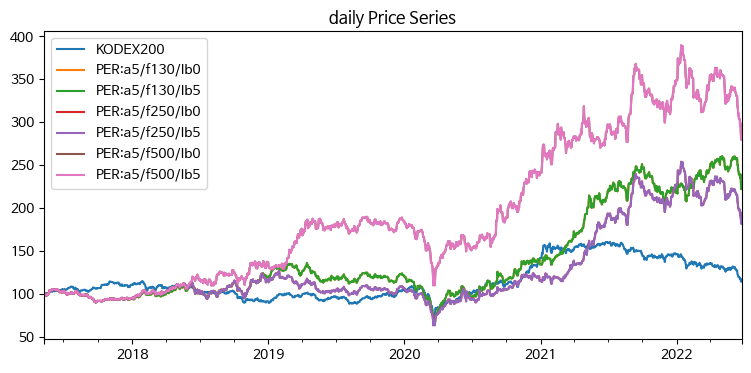

In [34]:
_ = bm.plot(pf_list, figsize=(9,4))

### Validation

In [35]:
bm = BacktestManager(df_test, **kwargs_bm)
bm.benchmark_ticker()

running self.util_check_days_in_year to check days in a year
171 assets from 2022-06-27 to 2024-07-05 uploaded.
Benchmark is KODEX200


In [36]:
from itertools import product

params = dict(
    p_fr = ['PER'],
    p_ast = [5, 10],
    p_freq = [130, 250, 500],
    p_lb = [0, 5, 10]
)
p_comb = list(product(*params.values()))
kwa_list = [{'name':f'{x[0]}:a{x[1]}/f{x[2]}/lb{x[3]}',
              'df_ratio':fratios_dict[x[0]], 'n_assets':x[1], 'freq':x[2], 'lookback':x[3]} 
            for x in p_comb]

kwargs_build = dict(
    select='F-ratio', weigh='Equally', ratio_descending=False
)

bm.build_batch(*kwa_list, **kwargs_build)
df_res = bm.run(stats_sort_by='cagr', plot=False)

Backtesting 19 strategies: KODEX200, PER:a5/f130/lb0, ... , PER:a10/f500/lb10


100%|███████████████████████████████████████████████████████████████| 19/19 [00:07<00:00,  2.65it/s]

Returning stats


In [37]:
#df_res = bm.get_stats(sort_by='monthly_sharpe')

In [38]:
df_res.iloc[:, :5]

,PER:a5/f130/lb0,PER:a5/f250/lb0,PER:a5/f250/lb5,PER:a5/f250/lb10,KODEX200
start,2022-06-26,2022-06-26,2022-06-26,2022-06-26,2022-06-26
end,2024-07-05,2024-07-05,2024-07-05,2024-07-05,2024-07-05
total_return,0.354263,0.337132,0.337132,0.337132,0.307593
cagr,0.161465,0.15419,0.15419,0.15419,0.141534
calmar,0.751864,0.717987,0.717987,0.717987,0.953443
max_drawdown,-0.214753,-0.214753,-0.214753,-0.214753,-0.148445
avg_drawdown,-0.061921,-0.057175,-0.057175,-0.057175,-0.030484
avg_drawdown_days,37.944444,34.05,34.05,34.05,25.269231
daily_vol,0.258318,0.260772,0.260772,0.260772,0.168761
daily_sharpe,0.719883,0.691137,0.691137,0.691137,0.88523


## Cross-validation

In [39]:
n_test = 500
df_train = df_k200.iloc[:-n_test]
df_test = df_k200.iloc[-n_test:]

In [40]:
kwargs_bm = dict(
    initial_capital = 1e7,
    commissions = 0,
    align_axis = None, 
    days_in_year = 246,
    asset_names = assetnames_k200
)

In [41]:
bm = BacktestManager(df_test, **kwargs_bm)

running self.util_check_days_in_year to check days in a year
171 assets from 2022-06-27 to 2024-07-05 uploaded.


In [42]:
from itertools import product

params = dict(
    p_fr = ['PER'],
    p_ast = [5, 10],
    p_freq = [130, 250, 500],
    p_lb = [0, 5, 10]
)
p_comb = list(product(*params.values()))
kwa_list = [{'name':f'{x[0]}:a{x[1]}/f{x[2]}/lb{x[3]}',
             'df_ratio':fratios_dict[x[0]], 'n_assets':x[1], 'freq':x[2], 'lookback':x[3]} 
            for x in p_comb]

kwargs_build = dict(
    select='F-ratio', weigh='Equally', ratio_descending=False
)

bm.build_batch(*kwa_list, **kwargs_build)

In [45]:
df_res = bm.cross_validate(n_sample=20)

Cross-validating 18 strategies: PER:a5/f130/lb0, PER:a5/f130/lb5, ... , PER:a10/f500/lb10


100%|███████████████████████████████████████████████████████████████| 17/17 [00:07<00:00,  2.38it/s]


In [47]:
m = ['cagr', 'max_drawdown', 'avg_drawdown', 'avg_drawdown_days', 'monthly_vol', 'monthly_sharpe']
df_res.T[m]

,cagr,max_drawdown,avg_drawdown,avg_drawdown_days,monthly_vol,monthly_sharpe
PER:a5/f130/lb0,0.09 ± 0.052,-0.19 ± 0.030,-0.07 ± 0.019,52.06 ± 23.186,0.19 ± 0.041,0.54 ± 0.257
PER:a5/f130/lb5,0.09 ± 0.052,-0.19 ± 0.029,-0.07 ± 0.021,54.48 ± 24.460,0.19 ± 0.039,0.50 ± 0.253
PER:a5/f130/lb10,0.09 ± 0.045,-0.19 ± 0.030,-0.07 ± 0.021,50.59 ± 21.019,0.20 ± 0.035,0.54 ± 0.211
PER:a5/f250/lb0,0.11 ± 0.057,-0.20 ± 0.019,-0.07 ± 0.026,57.01 ± 34.600,0.22 ± 0.039,0.56 ± 0.186
PER:a5/f250/lb5,0.10 ± 0.063,-0.21 ± 0.030,-0.08 ± 0.054,80.41 ± 108.021,0.22 ± 0.038,0.51 ± 0.231
PER:a5/f250/lb10,0.10 ± 0.055,-0.21 ± 0.023,-0.07 ± 0.027,61.43 ± 36.485,0.22 ± 0.037,0.53 ± 0.183
PER:a5/f500/lb0,0.02 ± 0.041,-0.21 ± 0.024,-0.08 ± 0.035,88.17 ± 55.666,0.19 ± 0.048,0.17 ± 0.203
PER:a5/f500/lb5,0.01 ± 0.047,-0.22 ± 0.030,-0.09 ± 0.052,104.33 ± 105.994,0.19 ± 0.046,0.14 ± 0.263
PER:a5/f500/lb10,0.02 ± 0.040,-0.22 ± 0.029,-0.08 ± 0.037,91.07 ± 54.597,0.19 ± 0.045,0.16 ± 0.212
PER:a10/f130/lb0,0.05 ± 0.042,-0.17 ± 0.019,-0.06 ± 0.021,63.31 ± 32.264,0.14 ± 0.044,0.33 ± 0.220


In [ ]:
#bm.cv_strategies

In [ ]:
#pf_list = list(range(6))
#bm.cross_validate(pf_list, n_sample=10)

# Transaction

In [14]:
df_ratio = fratios_dict['PER']

In [15]:
kw_per = dict(
    name='PER',
    method_select='f-ratio',
    sort_ascending=True,
    lookback=0, # days
    df_additional=df_ratio,
    method_weigh='equally',
    align_axis=None
)

kwargs = dict(
    #file='pf_k200_per.csv',
    file='test_per.csv',
    path=path_tran,
    days_in_year=246,
    asset_names=assetnames_k200,
    **kw_per
)

pf_per = MomentumPortfolio(df_k200, **kwargs)

201 assets from 2021-01-04 to 2024-10-17 uploaded.
running self.util_check_days_in_year to check days in a year
REMINDER: make sure this is 1st transaction as no records provided


In [16]:
pf_per.view_record()

ERROR: No transaction record


Portfolio value 5,304,050, Profit 7.5% on 2024-10-17


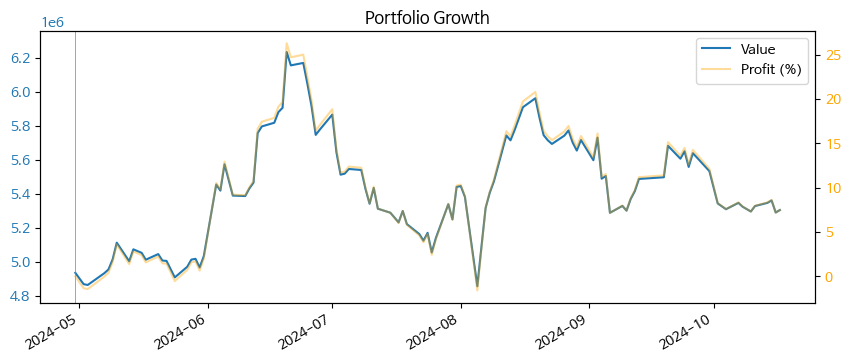

In [29]:
pf_per.valuate()

In [18]:
# set kwargs of transaction_pipeline
WidgetTransaction

In [21]:
kwargs_trs = dict(
    n_assets = 5,
    date = WidgetTransaction.values(0),
    capital = WidgetTransaction.values(1),
    save = WidgetTransaction.values(2)
)

_ = pf_per.transaction_pipeline(**kwargs_trs)
pf_per.view_record()

Liquidation set to None
5 assets selected by Financial Ratio from 2024-04-30 to 2024-04-30
Weights of assets determined by Equal weights.
Mean absolute error of weights: 1 %
Portfolio value 5,304,050, Profit 7.5% on 2024-10-17
Set save=True to save transaction record


name  price  transaction  net weight weight*
date       asset                                                   
2024-04-30 011200       HMM  15850           63   63  0.200  0.2023
           137310  에스디바이오센서  10540           94   94  0.200  0.2008
           016380      KG스틸   7120          140  140  0.200  0.2020
           036460    한국가스공사  27600           36   36  0.200  0.2013
           139480       이마트  63700           15   15  0.200  0.1936

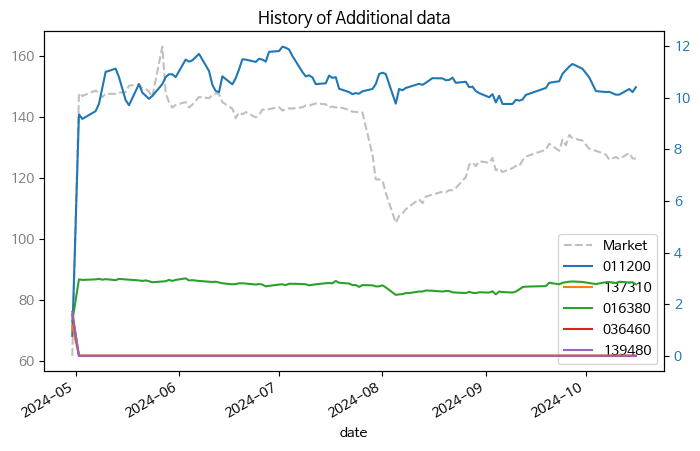

In [22]:
_ = pf_per.check_additional(plot=True)